# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.044363472121742


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 603.06
random: 278.0800000000001


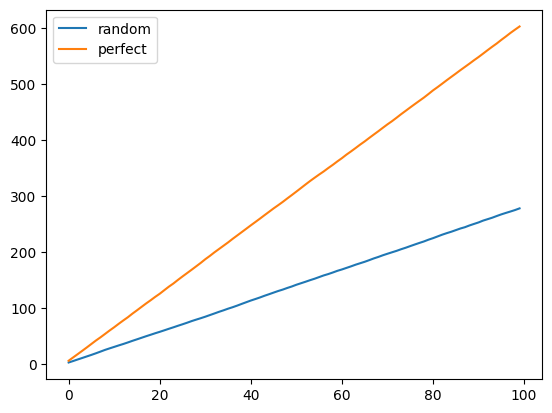

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.7
random: 3.0


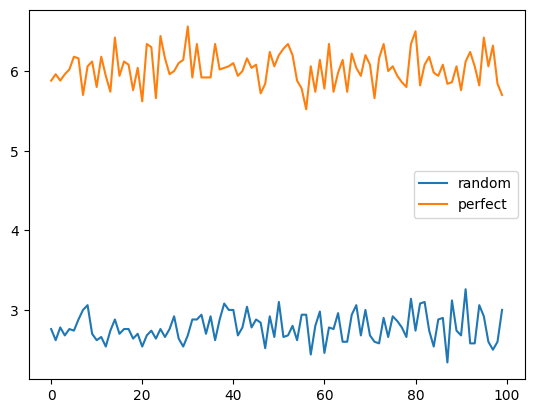

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.impressions = {arm_id: 0 for arm_id in arm_ids}    # Ilość rekomendacji (wyświetleń)
        self.clicks = {arm_id: 0 for arm_id in arm_ids}         # Ilość kliknięć (rekomendacja + kliknięcie)
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}          # Funkcja celu (kliki/impresje)
    
    def recommend(self, size):
        random_arms_ids = copy(arm_ids)
        shuffle(random_arms_ids)

        sorted_arms_ids = sorted(arm_ids, key=lambda arm_id: self.ctr[arm_id], reverse=True)

        recommendations = []
        i = 0

        while len(recommendations) < size:
            x = random()
            arm_to_add = None
            if x > self.epsilon:
                arm_to_add = sorted_arms_ids[i]
            else:
                arm_to_add = random_arms_ids[i]
            
            if arm_to_add not in recommendations:
                recommendations.append(arm_to_add)
                self.impressions[arm_to_add] += 1
            
            i = (i + 1) % size

        return recommendations
            
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.clicks[arm_id] += 1

        curr_payouts = self.ctr[arm_id] * self.impressions[arm_id]
        self.ctr[arm_id] = (curr_payouts + payout) / self.impressions[arm_id]


In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 1 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = len(arm_ids)
    
    def recommend(self, size):
        ctr_with_optimism = copy(self.ctr)

        for arm, ctr in ctr_with_optimism.items():
            ctr_with_optimism[arm] = ctr + self.optimism_weight * self._optimism(arm)
        
        recommend = sorted(arm_ids, key = lambda arm_id: ctr_with_optimism[arm_id], reverse=True)

        for i in range(size):
            arm_id = recommend[i]
            self.impressions[arm_id] += 1
        self.total_impressions += size

        return recommend[:size]
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.clicks[arm_id] += 1

        curr_payouts = self.ctr[arm_id] * self.impressions[arm_id]
        self.ctr[arm_id] = (curr_payouts + payout) / self.impressions[arm_id]

    def _optimism(self, arm):
        return sqrt(2 * log(self.total_impressions) / self.impressions[arm])

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        betavariates = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in arm_ids}

        recommend = sorted(arm_ids, key = lambda arm_id: betavariates[arm_id], reverse=True)

        return recommend[:size]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier

        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

perfect: 6.64
ts_5_1: 6.22
ts_10_50: 6.2
ts_5_5: 6.1
ts_1_5: 6.08
ts_20_5: 6.04
ts_1_10: 6.02
ts_1_20: 5.96
ts_5_10: 5.96
ts_1_1: 5.94
ts_5_20: 5.9
ts_10_1: 5.88
ts_1_50: 5.86
ts_20_1: 5.86
ts_10_20: 5.8
ts_5_50: 5.78
ucb_1: 5.74
ts_50_20: 5.6
ts_10_5: 5.52
ts_20_20: 5.52
ts_10_10: 5.42
ts_20_10: 5.4
ts_20_50: 5.36
ucb_10: 5.32
ts_50_5: 5.3
ts_50_1: 5.22
ts_50_50: 5.0
egreedy_0.25: 4.6
egreedy_0.01: 4.52
egreedy_0.1: 4.52
ts_50_10: 4.1
ucb_0.01: 3.94
egreedy_0.05: 3.8
ucb_0.1: 3.6
random: 2.8


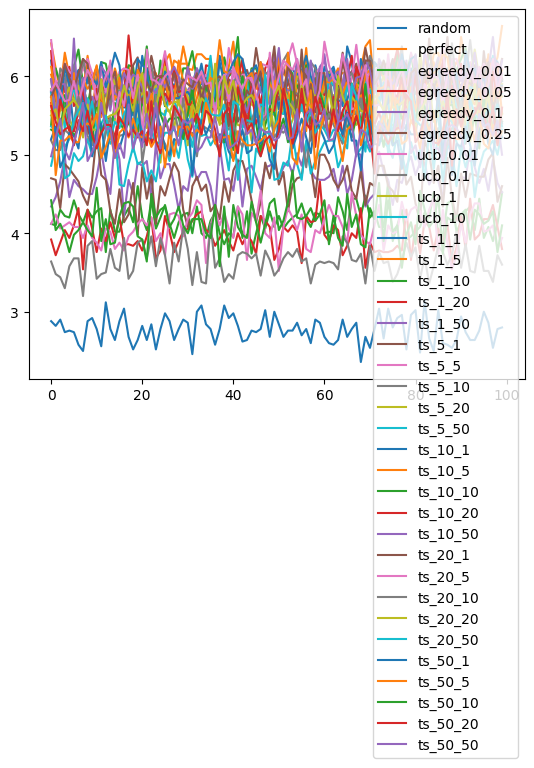

In [16]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 602.3400000000003
ts_5_5: 599.52
ts_5_1: 596.3800000000002
ts_1_10: 593.2399999999999
ts_10_1: 592.5199999999999
ts_10_50: 592.1400000000002
ts_5_10: 591.4599999999998
ts_1_20: 589.2600000000001
ts_1_50: 588.9600000000002
ts_20_1: 587.9000000000001
ts_20_5: 587.5399999999997
ts_1_1: 585.7800000000001
ts_10_5: 585.2399999999999
ts_1_5: 583.6399999999999
ts_5_20: 577.12
ts_5_50: 566.1599999999999
ts_20_20: 560.9799999999999
ts_10_20: 559.72
ucb_1: 557.58
ts_10_10: 547.94
ts_20_50: 539.5999999999999
ts_50_20: 536.9399999999998
ts_20_10: 534.6599999999997
ts_50_5: 528.8799999999998
ts_50_50: 526.8799999999998
ts_50_1: 523.3799999999998
ucb_10: 501.88000000000005
egreedy_0.1: 472.65999999999997
egreedy_0.25: 462.42000000000013
egreedy_0.01: 417.13999999999976
ts_50_10: 413.8600000000002
ucb_0.01: 407.9600000000001
egreedy_0.05: 397.32000000000005
ucb_0.1: 364.19999999999993
random: 277.1600000000001


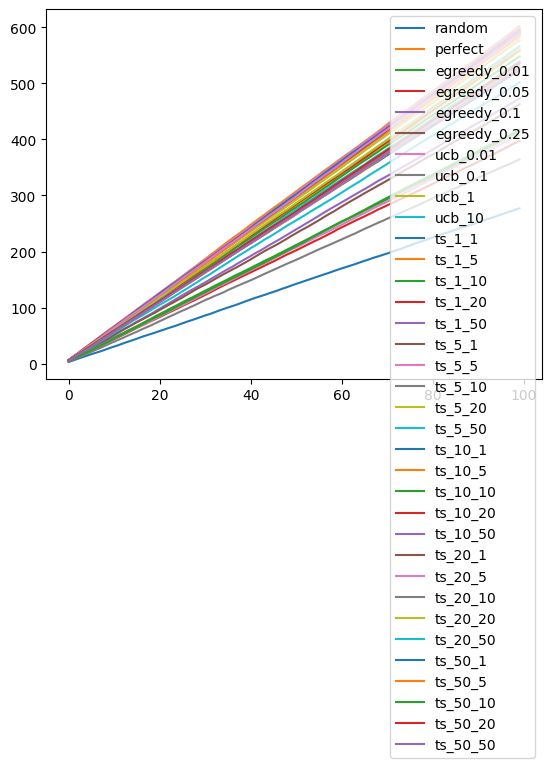

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [18]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [19]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:                     # dobre w top k / wszystkie w top k                                 
    top_k_recommendation = recommendation[:k]
    return relevant(top_k_recommendation) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:     # dobre w top k / wszystkie dobre   
    top_k_recommendation = recommendation[:k]
    if all_relevant == 0:
        return 10
    return relevant(top_k_recommendation) / all_relevant

In [20]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [21]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    return tabulate(data, headers, tablefmt='github')

In [22]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [
    bandit for bandit in bandits
    if bandit.bandit_id in ['perfect', 'random', 'egreedy_0.1', 'ucb_0.1', 'ts_1_1']]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# Symulacja i porównanie bandytów
results = []

for bandit in tesing_bandits:
    print(f"Testing bandit: {bandit.bandit_id}")
    
    # Symulacja bandyty (musisz wcześniej wywołać runner.simulate, by trenować bandytów)
    precisions = {k: 0 for k in k_vals}
    recalls = {k: 0 for k in k_vals}
    
    for _ in range(samples):
      
        recommendation_ids = bandit.recommend(recommendation_size)
        recommendation = [arms[arm_id] for arm_id in recommendation_ids]
        
        for k in k_vals:
            
            precisions[k] += precision_at_k(recommendation, k)                      # (TP)/(TP + FP)    Ile jest prawdziwych spośród wskazanych
            recalls[k] += recall_at_k(recommendation, k, all_relevant)              # (TP)/(TP + FN)    Ile wszystkich prwadziwych wskazaliśmy
            
    for k in k_vals:
        entry = TestEntry(bandit.bandit_id, k, precisions[k]/samples, recalls[k]/samples)
        results.append(entry)
        
print(print_test_results(results))

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci


Testing bandit: random
Testing bandit: perfect
Testing bandit: egreedy_0.1
Testing bandit: ucb_0.1
Testing bandit: ts_1_1
| bandit      |   k |   precision@k |   recall@k |
|-------------|-----|---------------|------------|
| egreedy_0.1 |   3 |      0.933333 |       0.28 |
| egreedy_0.1 |   5 |      0.92     |       0.46 |
| egreedy_0.1 |  10 |      0.56     |       0.56 |
| perfect     |   3 |      1        |       0.3  |
| perfect     |   5 |      1        |       0.5  |
| perfect     |  10 |      1        |       1    |
| random      |   3 |      0.266667 |       0.08 |
| random      |   5 |      0.16     |       0.08 |
| random      |  10 |      0.11     |       0.11 |
| ts_1_1      |   3 |      1        |       0.3  |
| ts_1_1      |   5 |      1        |       0.5  |
| ts_1_1      |  10 |      0.99     |       0.99 |
| ucb_0.1     |   3 |      1        |       0.3  |
| ucb_0.1     |   5 |      0.6      |       0.3  |
| ucb_0.1     |  10 |      0.3      |       0.3  |
